# Imports 

In [1]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "team_select_poc"
os.environ['LANGCHAIN_API_KEY'] = "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"

In [2]:
from typing import Any, TypedDict, Dict, Annotated
from pydantic import BaseModel
from operator import add
from IPython.display import Image, display, Markdown
from langchain.agents import (
    AgentExecutor,
    create_openai_tools_agent,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain.callbacks.base import BaseCallbackHandler
from langchain.schema import AgentAction
from langchain_openai import ChatOpenAI

import langgraph
from langgraph.graph import StateGraph, END
from chains import get_finish_chain, get_supervisor_chain
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage 


In [3]:
from tools import financial_metrics_tools
from prompts import get_financial_metrics_agent_prompt
from datetime import datetime
from llms import llm
from config import setup_environment

setup_environment()

# ALL IMPORTS
# from tools import financial_metrics_tools, news_sentiment_tools, market_intelligence_tools
# from prompts import get_financial_metrics_agent_prompt, get_news_sentiment_agent_prompt, get_market_intelligence_agent_prompt
# from sql_agent import query_database
# from datetime import datetime
# from llms import llm

def disp(text):
    display(Markdown(text))
    return

# LLM

In [4]:
llm

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x117c947a0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x117c13b90>, root_client=<openai.OpenAI object at 0x117c57800>, root_async_client=<openai.AsyncOpenAI object at 0x117c94800>, model_name='gpt-4o-mini', temperature=0.2, model_kwargs={}, openai_api_key=SecretStr('**********'))

# Config

In [5]:
settings = {
                "model": "gpt-4o-mini",
                "temperature": 0.3,
            }

# Callbacks

In [6]:
class CustomConsoleCallbackHandler(BaseCallbackHandler):
    def __init__(self):
        """Initialize the handler"""
        self.current_agent_name = None
        super().__init__()

    def write_agent_name(self, name: str):
        """Display agent name"""
        self.current_agent_name = name
        print(f"\n=== Agent: {name} ===")

    def on_tool_start(self, serialized: Dict[str, Any], input_str: str, **kwargs):
        """Display tool execution start"""
        print(f"\n🔧 Using tool: {serialized['name']}")

    def on_tool_end(self, output: str, **kwargs):
        """Display tool execution result"""
        print("\n📤 Tool output:")
        print("-" * 50)
        print(output)
        print("-" * 50)

    def on_agent_action(self, action: AgentAction, **kwargs):
        """Display agent action"""
        print(f"\n🎯 Action: {action.tool}")
        print("Input:")
        print("-" * 50)
        print(action.tool_input)
        print("-" * 50)

    def on_llm_start(self, serialized: Dict[str, Any], prompts: list[str], **kwargs):
        """Display when LLM starts processing"""
        print("\n🤔 Processing...")

    def on_llm_end(self, response, **kwargs):
        """Display final LLM response"""
        if hasattr(response, 'generations') and response.generations:
            print("\n Final LLM Response:")
            print("-" * 50)
            print(response.generations[0][0].text)
            print("-" * 50)

    def on_tool_error(self, error: str, **kwargs):
        """Display tool errors"""
        print(f"\n❌ Error: {error}")

# States

### News Sentiment Agent Internal State

In [7]:
class TopicAdherenceEval(BaseModel):
    passed: Annotated[list[Any] , add] # will hold values of True or False
    reason: Annotated[list[Any] , add] # will hold reasons for the True or False

# Add state for all_tools_called_eval
class AllToolsEval(BaseModel):
    passed: Annotated[list[Any], add]  # bool value for if evalution passed = all tools were called successfully
    stats: Annotated[list[Any] , add]  # stats for each tool call, errors etc..
    
# Pydantic structure for model to evaluate response:
class LLM_TopicAdherenceEval(BaseModel):
    passed: str
    reason: str

class SentimentNewsState(BaseModel):
    agent_executor_tools: dict 
    full_response: dict
    all_tools_eval: AllToolsEval                    # Annotated[list[Any], add]
    topic_adherence_eval: TopicAdherenceEval        # Annotated[list[TopicAdherenceEval] , add]



### Financial Metrics Agent Internal State

In [8]:
class FinancialMetricsState(BaseModel):
    agent_executor_tools: dict 
    full_response: dict
    all_tools_eval: AllToolsEval                    # Annotated[list[Any], add]
    topic_adherence_eval: TopicAdherenceEval        # Annotated[list[TopicAdherenceEval] , add]


### Overall State

In [9]:
from personality import AgentPersonality

# Personality - default
sample_personality = AgentPersonality()
    
# OVERALL AGENT STATE
class AgentState(TypedDict):
    current_date: datetime
    user_input: str
    messages: list[BaseMessage]
    next_step: str
    config: dict
    callback: Any
    personality: AgentPersonality
    news_sentiment_agent_internal_state: SentimentNewsState
    financial_metrics_agent_internal_state: FinancialMetricsState
    # we can have internal states for all agents

# sample state:
# state = {   
#     "current_date": datetime.now(),
#     "messages": list(message_history.messages) + [prompt],
#     "user_input": prompt,
#     "config": settings,
#     "callback": callback_handler,
#     "personality": sample_personality
# }


# Helper Functions

**CREATE AGENT**

In [10]:
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str, max_iterations: int = 2,  return_intermediate_steps: bool = True) -> AgentExecutor:
    """
    Creates an agent using the specified ChatOpenAI model, tools, and system prompt.

    Args:
        llm : LLM to be used to create the agent.
        tools (list): The list of tools to be given to the worker node.
        system_prompt (str): The system prompt to be used in the agent.

    Returns:
        AgentExecutor: The executor for the created agent.
    """
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, max_iterations = max_iterations, return_intermediate_steps = return_intermediate_steps, verbose = True)
    return executor

**GET TOOLS CALL EVAL STATS**

In [11]:
def get_tools_call_eval_stats(result: Dict):
    """Helper function to format the output and store evaluation stats"""
    print("\n📊 TOOL EVALUATION SUMMARY")
    print("=" * 50)
    
    # Create stats dictionary to store in state
    run_stats = {
        "timestamp": datetime.now(),
        "all_tools_used": result["all_tools_used"],
        "tool_counts": result['tool_usage']['call_counts'],
        "errors": {
            "invalid_tools": result['tool_usage']['errors']['invalid_tools'],
            "execution_errors": result['tool_usage']['errors']['execution_errors'],
            "parser_errors": result['tool_usage']['errors']['parser_errors']
        }
    }
    
    # Print evaluation results
    all_tools_status = "✅" if result["all_tools_used"] else "❌"
    print(f"\n🎯 Overall Status:")
    print(f"  • All Required Tools Used: {all_tools_status}")
    
    print(f"\n📋 Tool Inventory:")
    print(f"  • Available Tools: {', '.join(result['tool_usage']['available_tools'])}")
    print(f"  • Successfully Used: {', '.join(result['tool_usage']['used_tools'])}")
    print(f"  • Not Used: {', '.join(result['tool_usage']['unused_tools'])}")
    
    print("\n📈 Usage Statistics:")
    for tool, count in result['tool_usage']['call_counts'].items():
        status = "✅" if count > 0 else "❌"
        print(f"  {status} {tool}: {count} calls")
    
    # Error Summary
    has_errors = any(len(errs) > 0 for errs in result['tool_usage']['errors'].values())
    if has_errors:
        print("\n⚠️ Error Summary:")
        errors = result['tool_usage']['errors']
        
        if errors['invalid_tools']:
            print("\n  Invalid Tool Attempts:")
            for err in errors['invalid_tools']:
                print(f"  • Requested: {err['requested']}")
                print(f"    Available: {', '.join(err['available'])}")
        
        if errors['execution_errors']:
            print("\n  Tool Execution Errors:")
            for err in errors['execution_errors']:
                print(f"  • Tool: {err['tool']}")
                print(f"    Input: {err['input']}")
                print(f"    Error: {err['error']}")
        
        if errors['parser_errors']:
            print("\n  Parser Errors:")
            for err in errors['parser_errors']:
                print(f"  • Input: {err['input']}")
                print(f"    Error: {err['error']}")
    
    print("\n🔍 Detailed Tool Execution Log:")
    for step in result["tools_used"]:
        status_emoji = {
            "success": "✅",
            "parser_error": "🔍",
            "invalid_tool": "❌",
            "execution_error": "⚠️"
        }.get(step['status'], "❓")
        
        print(f"\n  {status_emoji} Tool: {step['tool']}")
        print(f"    Status: {step['status']}")
        print(f"    Input: {step['input']}")
        if step['status'] == "success":
            print(f"    Output: {str(step['output'])[:100]}...")  # Truncate long outputs
    
    print("\n" + "=" * 50)
    
    return run_stats

# PROMPTS

In [12]:
# make this prompt flexible! 

In [13]:
TOPIC_ADHERENCE_PROMPT = """You are a specialized evaluator assessing the relevance and comprehensiveness of responses from the Financial Metrics Agent.

The Financial Metrics Agent is designed to provide:
- Core financial statement analysis (income statement, balance sheet, cash flow)
- Valuation metrics & ratios (P/E, EPS, etc.)
- Company fundamentals (market cap, industry, sector)
- Industry comparisons and benchmarks

The user asked:
{question}

The Agent responded with:
{answer}

Evaluate if the answer effectively addresses the user's question by providing relevant financial analysis and metrics.

Your response must be valid JSON matching this exact format:
{{
    "passed": "true" or "false", 
    "reason": "Brief explanation of your evaluation"
}}

Guidelines for evaluation:
- "passed" should be "true" if the answer:
  * Directly addresses the main points of the question
  * Includes relevant financial metrics and ratios
  * Provides company fundamental data and industry context
  * Uses data from financial statements to support analysis

- "passed" should be "false" if the answer:
  * Is off-topic or misses the core question
  * Lacks key financial metrics or ratios
  * Fails to include fundamental data or industry context
  * Provides incomplete or superficial financial analysis

- The "reason" should specifically explain how well the response incorporated financial metrics, fundamental data, and industry analysis in addressing the query
"""

# NODES

In [14]:
financial_metrics_tools

[StructuredTool(name='get_stock_price', description='Fetch the current stock price and key market data for the given symbol.', args_schema=<class 'langchain_core.utils.pydantic.get_stock_price'>, func=<function get_stock_price at 0x117c67d80>),
 StructuredTool(name='get_company_financials', description='Fetch basic financial information for the given company symbol such as the industry, the sector, the name of the company, and the market capitalization.', args_schema=<class 'langchain_core.utils.pydantic.get_company_financials'>, func=<function get_company_financials at 0x120636840>),
 StructuredTool(name='get_income_statement', description='Fetch last income statement for the given company symbol such as revenue, gross profit, net income, EBITDA, EPS.', args_schema=<class 'langchain_core.utils.pydantic.get_income_statement'>, func=<function get_income_statement at 0x120635440>),
 StructuredTool(name='get_balance_sheet', description="Fetch the balance sheet statement for a given compan

In [15]:
def financial_metrics_node(state):
    """
    Handles fundamental analysis and financial metrics using tools from tools.py
    """
    print("\n" + "-"*50)
    print("📊 FINANCIAL METRICS NODE")
    
    metrics_agent = create_agent(
        llm,
        financial_metrics_tools,
        get_financial_metrics_agent_prompt(state.get("current_date"), state.get("personality"), state.get("user_input"))
    )
    
    state["callback"].write_agent_name("Financial Metrics Agent 📊")
    output = metrics_agent.invoke(
        {"messages": state["messages"]}, {"callbacks": [state["callback"]]}, return_intermediate_steps = True
    )
    print(f"Analysis complete - Output length: {len(output.get('output', ''))}")
    
    state["messages"].append(
        AIMessage(content=output.get("output"), name="FinancialMetrics")
    )
    # ADDED: financial_metrics_agent tools:
    available_tools = {tool.name: 0 for tool in metrics_agent.tools}                                           
    state["financial_metrics_agent_internal_state"]["agent_executor_tools"] = available_tools
    state["financial_metrics_agent_internal_state"]["full_response"] = output # output contains all the messages

    print("-"*50 + "\n")
    return state

# Evaluate all tools called:
def evaluate_all_tools_called(state):
    """Evaluates tool usage and stores statistics in state"""
    sample_response = state['financial_metrics_agent_internal_state']
    print("INSIDE EVALUATE ALL TOOLS CALLED: ", sample_response)
    
    # This dictionary will be used for later evaluation statistics
    result = {
        "answer": sample_response['full_response']["output"],
        "tools_used": [],
        "all_tools_used": False,
        "tool_usage": {
            "available_tools": list(sample_response['agent_executor_tools'].keys()),
            "used_tools": set(),
            "unused_tools": set(),
            "call_counts": sample_response['agent_executor_tools'].copy(),
            "errors": {
                "invalid_tools": [],
                "execution_errors": [],
                "parser_errors": []
            }
        }
    }

    # Process intermediate steps
    for action, observation in sample_response['full_response']["intermediate_steps"]:
        # print( 'ACTION: ', action)
        # print(' OBSERVATION: ', observation)
        tool_name = action.tool
        tool_input = action.tool_input
        
        # Determine status based on observation
        status = "success"  # Default, but will be immediately evaluated
        
        if tool_name == "_Exception":
            status = "parser_error"
            result["tool_usage"]["errors"]["parser_errors"].append({
                "input": tool_input,
                "error": observation
            })
        elif isinstance(observation, dict) and "requested_tool_name" in observation:
            status = "invalid_tool"
            result["tool_usage"]["errors"]["invalid_tools"].append({
                "requested": tool_name,
                "available": observation.get("available_tool_names", [])
            })
        elif isinstance(observation, dict) and next(iter(observation), "").lower().startswith("error"):
            
            status = "execution_error"
            result["tool_usage"]["errors"]["execution_errors"].append({
                "tool": tool_name,
                "input": tool_input,
                "error": observation
            })

        tool_result = {
            "tool": tool_name,
            "input": tool_input,
            "output": observation,
            "status": status
        }
        
        # Only count successful executions in usage statistics
        if status == "success":
            result["tool_usage"]["used_tools"].add(tool_name)
            result["tool_usage"]["call_counts"][tool_name] += 1

        result["tools_used"].append(tool_result)

    # Calculate unused tools
    
    # Set of tool names (strings) that were available but not used
    result["tool_usage"]["unused_tools"] = set(result["tool_usage"]["available_tools"]) - result["tool_usage"]["used_tools"]
    result["all_tools_used"] = len(result["tool_usage"]["unused_tools"]) == 0

    # Store evaluation stats in state
    run_stats = get_tools_call_eval_stats(result)
    
    # Initialize all_tools_eval if needed
    if 'stats' not in state['financial_metrics_agent_internal_state']['all_tools_eval']:
        state['financial_metrics_agent_internal_state']['all_tools_eval'] = {
            'stats': [],
            'passed': []
        }
    
    # Append new stats and pass/fail status
    state['financial_metrics_agent_internal_state']['all_tools_eval']['stats'].append(run_stats)
    state['financial_metrics_agent_internal_state']['all_tools_eval']['passed'].append(result["all_tools_used"])
    
    return state

def evaluate_topic_adherence(state):
    print(' INSIDE evaluate_topic_adherence')
    messages = [
        SystemMessage(content=TOPIC_ADHERENCE_PROMPT.format(
            question=state['user_input'],
            answer= state['financial_metrics_agent_internal_state']['full_response']['output']
        ))
    ]
    llm_evaluator = llm.with_structured_output(LLM_TopicAdherenceEval)
    response = llm_evaluator.invoke(messages)
    
    # Append to the internal state:
    state['financial_metrics_agent_internal_state']['topic_adherence_eval']['passed'].append(response.passed)
    state['financial_metrics_agent_internal_state']['topic_adherence_eval']['reason'].append(response.reason)
    return state

# EDGES

In [16]:
def execute_again_all_tools_called(state):
    print("INSIDE execute_again_all_tools_called")
    # all_tools_called_eval_passed will contain a booleean
    passed = state['financial_metrics_agent_internal_state']['all_tools_eval']['passed'][-1]
    iterations = len(state['financial_metrics_agent_internal_state']['all_tools_eval']['passed'])
    print("passed value:" ,passed )
    print('iterations: ', iterations, 'values: ' , state['financial_metrics_agent_internal_state']['all_tools_eval']['passed'])

    if passed or iterations >= 2:
   
        return "EvaluateTopicAdherence"
    else:
        print('GO BACK TO THE AGENT, tools not passed')
        return "FinancialMetricsAgent"

def execute_again_topic_adherence(state):
    print('INSIDE execute_again_topic_adherence')
    
    # Check if 'topic_adherence_eval' has any evaluations
    if not state['financial_metrics_agent_internal_state']['topic_adherence_eval']['passed']:
        print("No topic adherence evaluations found.")
        return "NewsSentimentAgent"  
    
    # Access the latest evaluation
    last_passed = state['financial_metrics_agent_internal_state']['topic_adherence_eval']['passed'][-1].lower()
    # Check how many evaluations occured
    iterations = len(state['financial_metrics_agent_internal_state']['topic_adherence_eval']['passed'])
    
    print("TOPIC ADHERENCE EVALUATION PASSED:", last_passed)
    print("NUMBER OF ITERATIONS FOR TOPIC ADHERENCE:", iterations)

    if last_passed == "true" or iterations >= 2: 
        print(f'ENDING! iterations {iterations}, value of topic_adherence: {last_passed}')
        return "end"
    else:
        print(f'RETURN TO AGENT, adherence failed! iterations {iterations}, value of topic_adherence: {last_passed}')
        return "FinancialMetricsAgent"



# Define and Build the Graph

In [17]:
def define_graph():
    """
    Defines and returns a graph representing the financial analysis workflow.
    """
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("FinancialMetricsAgent", financial_metrics_node)
    workflow.add_node("EvaluateAllToolsCalled", evaluate_all_tools_called)
    workflow.add_node("EvaluateTopicAdherence", evaluate_topic_adherence)
    
    # Set entry point
    workflow.set_entry_point("FinancialMetricsAgent")
    
    # Add edges
    workflow.add_edge("FinancialMetricsAgent", "EvaluateAllToolsCalled")
    
    workflow.add_conditional_edges("EvaluateAllToolsCalled", execute_again_all_tools_called, 
    {
        "EvaluateTopicAdherence": "EvaluateTopicAdherence", 
        "FinancialMetricsAgent": "FinancialMetricsAgent"
    }
      )
    
    workflow.add_conditional_edges("EvaluateTopicAdherence", execute_again_topic_adherence,                           
    {
        "end": END, 
        "FinancialMetricsAgent": "FinancialMetricsAgent"
    }
      )
                            
    return workflow.compile()

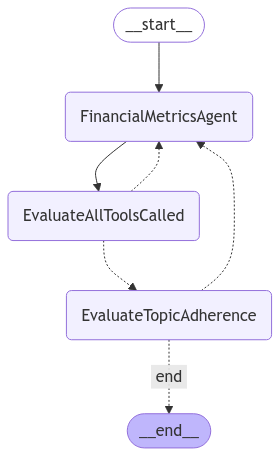

In [18]:
graph = define_graph()
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))

# Test the Agent

In [19]:
def test_agent(agent: langgraph.graph.state.CompiledStateGraph, question: str, verbose: bool = True):
    """Run a test query through the agent"""
    callback_handler = CustomConsoleCallbackHandler()
    # callback.verbose = verbose
   
    initial_state = {
        "current_date": datetime.now(),
        "user_input": question,
        "messages": [],
        "next_step": "",
        "config": settings,
        "callback": callback_handler,
        "personality": sample_personality,
        "news_sentiment_agent_internal_state": {
            "agent_executor_tools": {},
            "full_response": {},
            "all_tools_eval": {
                "stats": [],
                "passed": []
            },
            "topic_adherence_eval": {
                "passed": [],
                "reason": []
            }
        },
        # Added financial metrics agent internal state
        "financial_metrics_agent_internal_state": {
            "agent_executor_tools": {},
            "full_response": {},
            "all_tools_eval": {
                "stats": [],
                "passed": []
            },
            "topic_adherence_eval": {
                "passed": [],
                "reason": []
            }
        }
    }
    # Run the agent
    response = graph.invoke(initial_state)
    
    return response

In [20]:
# TESTING AFTER LATEST CHANGES PUSED TO GITHUB
response_LATEST_CODE = test_agent(graph , "How would you compare the market potential of the companies Celanese and CF Industried", verbose = False)


--------------------------------------------------
📊 FINANCIAL METRICS NODE

=== Agent: Financial Metrics Agent 📊 ===


> Entering new AgentExecutor chain...

🤔 Processing...

 Final LLM Response:
--------------------------------------------------

--------------------------------------------------

🎯 Action: get_stock_price
Input:
--------------------------------------------------
{'symbol': 'CE'}
--------------------------------------------------

Invoking: `get_stock_price` with `{'symbol': 'CE'}`



🔧 Using tool: get_stock_price

📤 Tool output:
--------------------------------------------------
{'symbol': 'CE', 'name': 'Celanese Corporation', 'price': 73.21, 'change': 0.3, 'changesPercentage': 0.4115, 'dayLow': 72.5, 'dayHigh': 74.45, 'yearLow': 71.38, 'yearHigh': 172.16, 'volume': 2884326, 'avgVolume': 1698514, 'priceAvg50': 113.6422, 'priceAvg200': 137.63506, 'eps': 10.04, 'pe': 7.29}
--------------------------------------------------
{'symbol': 'CE', 'name': 'Celanese Corporati

In [55]:
response = test_agent(graph , "How would you compare the market potential of the companies Celanese and CF Industried", verbose = False)


--------------------------------------------------
📊 FINANCIAL METRICS NODE

=== Agent: Financial Metrics Agent 📊 ===


> Entering new AgentExecutor chain...

🤔 Processing...

 Final LLM Response:
--------------------------------------------------

--------------------------------------------------

🎯 Action: get_stock_price
Input:
--------------------------------------------------
{'symbol': 'CE'}
--------------------------------------------------

Invoking: `get_stock_price` with `{'symbol': 'CE'}`



🔧 Using tool: get_stock_price

📤 Tool output:
--------------------------------------------------
{'symbol': 'CE', 'name': 'Celanese Corporation', 'price': 74.7, 'change': -0.3, 'changesPercentage': -0.4, 'dayLow': 74.655, 'dayHigh': 76.0999, 'yearLow': 71.38, 'yearHigh': 172.16, 'volume': 2839158, 'avgVolume': 1575337, 'priceAvg50': 117.6844, 'priceAvg200': 139.1252, 'eps': 10.04, 'pe': 7.44}
--------------------------------------------------
{'symbol': 'CE', 'name': 'Celanese Corporat

In [56]:
disp(response["messages"][0].content)

Agent stopped due to max iterations.

In [61]:
disp(response['financial_metrics_agent_internal_state']['full_response']['output'])

### Comprehensive Financial Analysis: Celanese Corporation (CE) vs. CF Industries Holdings, Inc. (CF)

#### 1. Market Position
- **Celanese Corporation (CE)**
  - **Current Price**: $74.70
  - **Market Cap**: $8.17 billion
  - **PE Ratio**: 7.44
  - **Beta**: 1.304 (higher volatility than the market)
  - **Industry**: Chemicals
  - **Year Range**: Low $71.38 - High $172.16

- **CF Industries Holdings, Inc. (CF)**
  - **Current Price**: $89.79
  - **Market Cap**: $15.63 billion
  - **PE Ratio**: 14.23
  - **Beta**: 0.957 (lower volatility than the market)
  - **Industry**: Agricultural Inputs
  - **Year Range**: Low $69.13 - High $91.06

**Industry Context**: CE operates in the chemicals sector, which is sensitive to economic cycles, while CF is in agricultural inputs, which can be more stable due to consistent demand for food production.

#### 2. Financial Statement Analysis
- **Celanese Corporation (CE)**
  - **Revenue (2023)**: $10.94 billion
  - **Net Income**: $1.96 billion
  - **EBITDA**: $2.61 billion
  - **Gross Profit Margin**: 23.7%
  - **Current Ratio**: 1.53
  - **Total Debt**: $14.10 billion
  - **Debt to Equity Ratio**: 1.99

- **CF Industries Holdings, Inc. (CF)**
  - **Revenue (2023)**: $6.63 billion
  - **Net Income**: $1.53 billion
  - **EBITDA**: $3.13 billion
  - **Gross Profit Margin**: 38.4%
  - **Current Ratio**: 3.81
  - **Total Debt**: $3.23 billion
  - **Debt to Equity Ratio**: 0.57

**Insights**: CF shows a stronger gross profit margin and a significantly lower debt-to-equity ratio, indicating better financial health and less leverage compared to CE.

#### 3. Valuation Assessment
- **Celanese Corporation (CE)**
  - **PE Ratio**: 7.44 (below industry average, indicating potential undervaluation)
  - **EPS**: $18.01

- **CF Industries Holdings, Inc. (CF)**
  - **PE Ratio**: 14.23 (higher than CE, suggesting a premium valuation)
  - **EPS**: $7.89

**Valuation Insight**: CE appears undervalued based on its PE ratio compared to CF, which may indicate a buying opportunity if the market corrects.

#### 4. Growth & Risk Analysis
- **Growth Metrics**
  - **CE**: Revenue growth has been strong, but the company faces significant debt.
  - **CF**: Consistent revenue and profit margins with lower volatility.

- **Risk Indicators**
  - **CE**: Higher beta indicates more market risk.
  - **CF**: Lower beta suggests stability.

**Future Outlook**: CE may offer higher growth potential if it can manage its debt effectively, while CF provides stability and consistent returns.

#### 5. Investment Implications
- **Key Strengths**
  - **CE**: Undervalued with strong revenue growth potential.
  - **CF**: Strong financial health, lower debt, and stable earnings.

- **Major Concerns**
  - **CE**: High leverage and market volatility.
  - **CF**: Higher valuation may limit upside potential.

- **Actionable Recommendations**
  - For a **moderate risk tolerance** investor, consider a **blend** of both stocks. CE offers growth potential at a lower valuation, while CF provides stability and consistent returns.
  - Monitor CE's debt management and market conditions closely, as these factors will influence its recovery and growth trajectory.

### Conclusion
Both companies have distinct advantages and risks. CE may present a higher risk/reward scenario, while CF offers a more stable investment profile. Your choice should align with your investment goals and risk tolerance.

In [63]:
response['financial_metrics_agent_internal_state']['topic_adherence_eval']

{'passed': ['false', 'true'],
 'reason': ["The response does not address the user's question at all, as it simply states that the agent stopped due to max iterations. There is no financial analysis, metrics, or comparison provided between Celanese and CF Industries, which are essential to evaluate their market potential.",
  "The response effectively compares the market potential of Celanese and CF Industries by providing relevant financial metrics such as market cap, PE ratio, revenue, net income, and debt levels. It includes a thorough analysis of each company's financial statements, industry context, growth and risk factors, and actionable investment implications, addressing the user's question comprehensively."]}

**questions**
ask reetu about adding messages to context relating if eval was succesfull or not
why error dividing by zero?

# EXAMPLE OF EVALUATION:

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from textwrap import wrap

In [66]:
# evaluation details will be found here:
all_tools_eval_results =response['financial_metrics_agent_internal_state']['all_tools_eval']
topic_adherence_eval_results =response['financial_metrics_agent_internal_state']['topic_adherence_eval']

## **All tools called analysis**

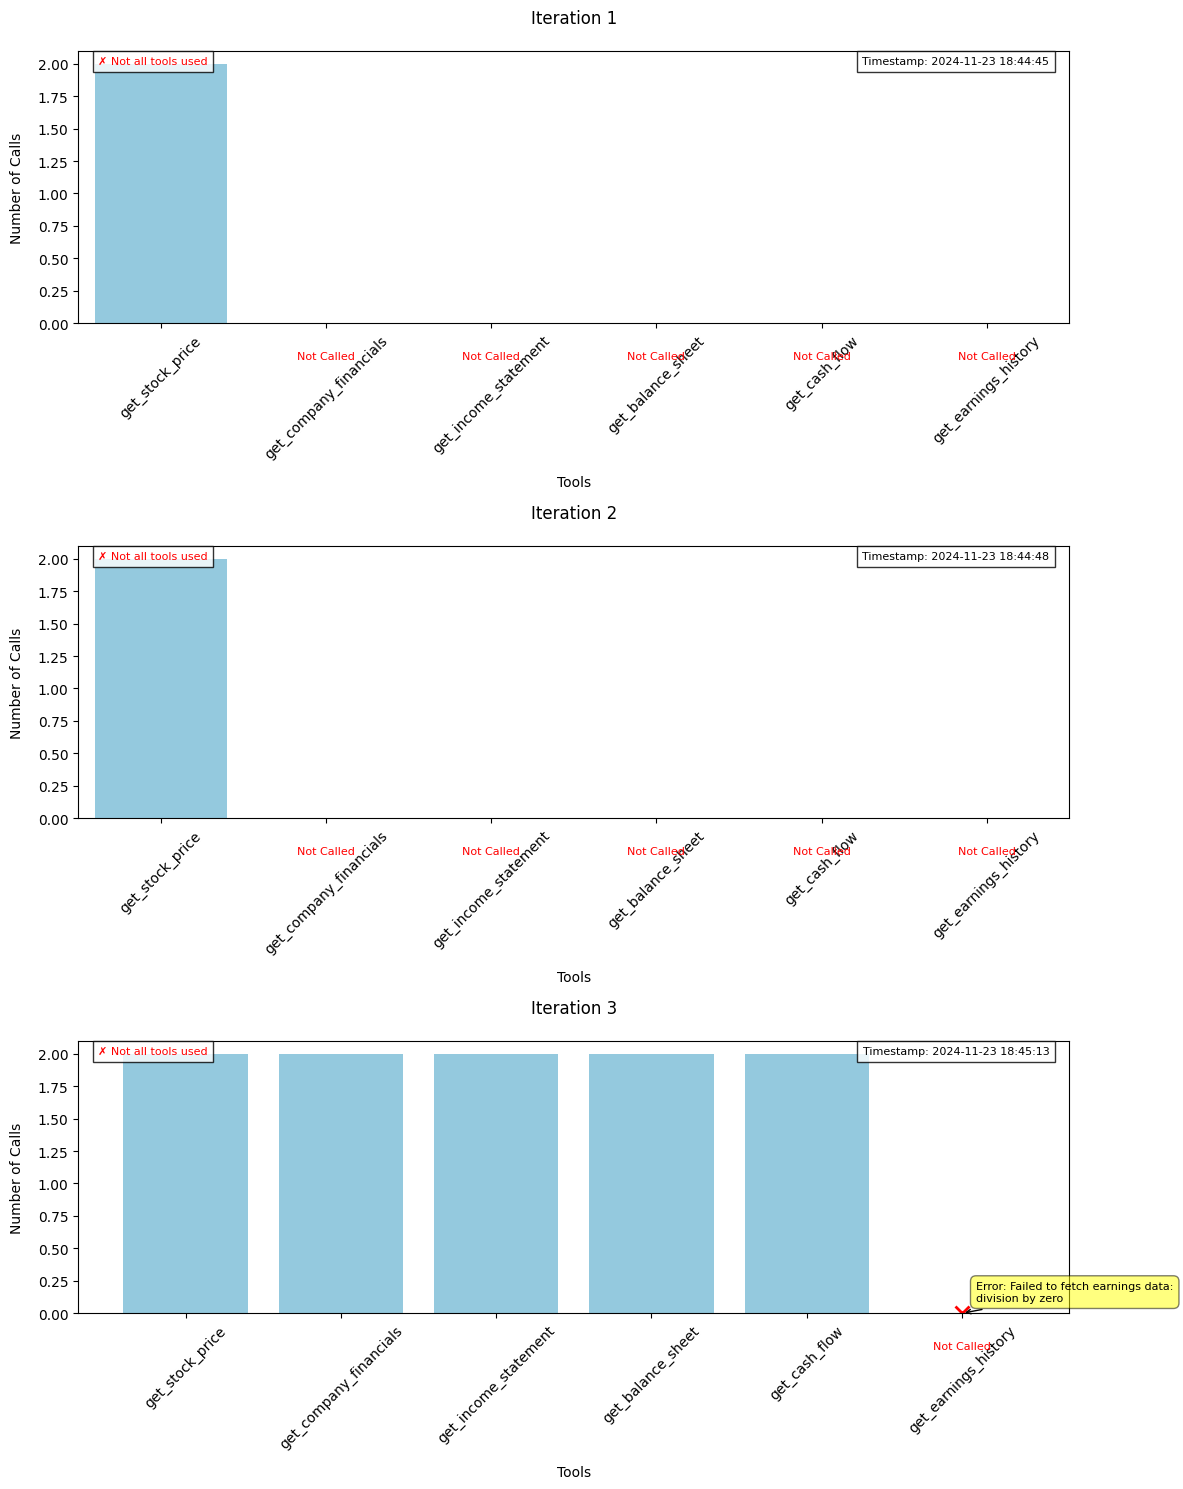

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from textwrap import wrap

# Calculate number of iterations and set up the subplots
n_iterations = len(all_tools_eval_results['stats'])
fig, axes = plt.subplots(n_iterations, 1, figsize=(12, 5*n_iterations))
if n_iterations == 1:
    axes = [axes]  # Convert to list for consistent indexing

# Process each iteration
for iteration_idx, (ax, iteration_stats) in enumerate(zip(axes, all_tools_eval_results['stats'])):
    # Create DataFrame for this iteration
    tool_counts = iteration_stats['tool_counts']
    
    # Create a mapping of tools to their error messages
    error_messages = {}
    for error in iteration_stats['errors']['execution_errors']:
        tool = error['tool']
        error_msg = error['error'].get('error', str(error['error']))
        error_messages[tool] = error_msg
    
    # Create DataFrame for this iteration
    iteration_data = []
    for tool, count in tool_counts.items():
        has_error = tool in error_messages
        iteration_data.append({
            'Tool': tool,
            'Calls': count,
            'Has Error': has_error,
            'Error Message': error_messages.get(tool, 'No error')
        })
    
    df = pd.DataFrame(iteration_data)
    
    # Create bar plot for this iteration
    sns.barplot(
        data=df,
        x='Tool',
        y='Calls',
        ax=ax,
        color='skyblue'
    )
    
    # Add error markers and annotations
    for idx, row in df.iterrows():
        if row['Has Error']:
            # Plot red X
            ax.plot(
                idx,
                row['Calls'],
                'rx',
                markersize=10,
                markeredgewidth=2,
                label='Error'
            )
            
            # Add error message annotation
            ax.annotate(
                f"Error: {row['Error Message']}",
                xy=(idx, row['Calls']),
                xytext=(10, 10),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
                fontsize=8,
                wrap=True
            )
        
        # Add annotation for zero calls
        if row['Calls'] == 0:
            ax.annotate(
                'Not Called',
                xy=(idx, 0),
                xytext=(0, -20),
                textcoords='offset points',
                ha='center',
                va='top',
                color='red',
                fontsize=8
            )
    
    # Customize subplot
    ax.set_title(f'Iteration {iteration_idx + 1}', pad=20, size=12)
    ax.set_xlabel('Tools', labelpad=10)
    ax.set_ylabel('Number of Calls', labelpad=10)
    ax.tick_params(axis='x', rotation=45)
    
    # Add timestamp
    timestamp = iteration_stats['timestamp'].strftime('%Y-%m-%d %H:%M:%S')
    ax.text(0.98, 0.98, f'Timestamp: {timestamp}', 
            transform=ax.transAxes, 
            ha='right', 
            va='top', 
            fontsize=8, 
            bbox=dict(facecolor='white', alpha=0.8))
    
    # Add all_tools_used status
    status_text = "✓ All tools used" if iteration_stats['all_tools_used'] else "✗ Not all tools used"
    ax.text(0.02, 0.98, status_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=8,
            color='green' if iteration_stats['all_tools_used'] else 'red',
            bbox=dict(facecolor='white', alpha=0.8))

# Adjust layout
plt.tight_layout()
plt.show()

## **Topic Adherence Eval**

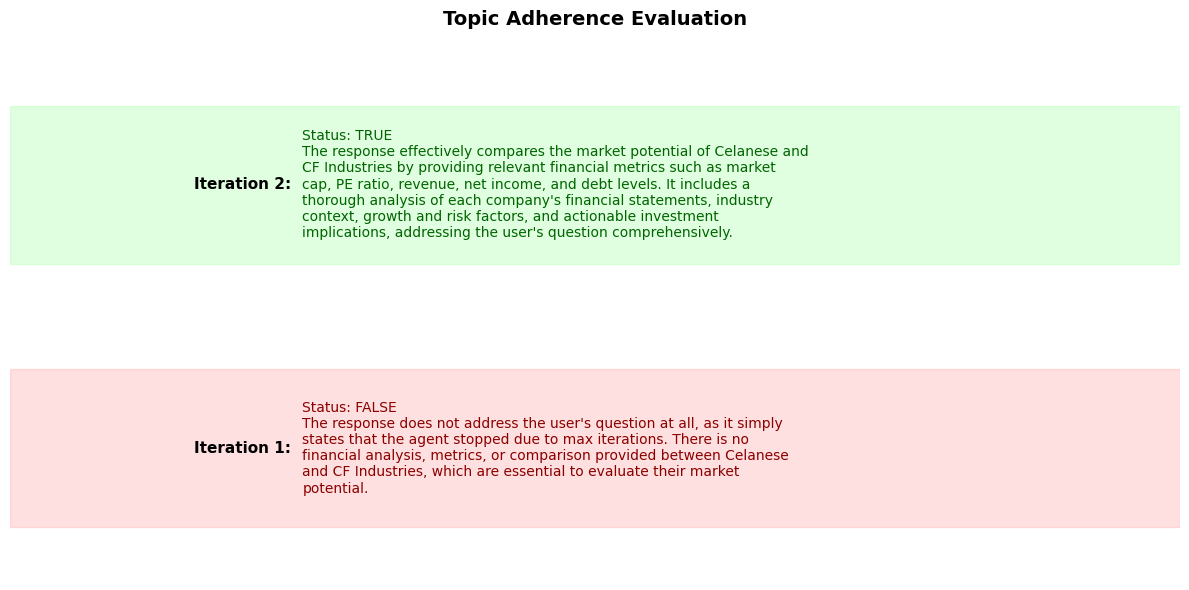

In [68]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Create data for visualization
iterations = len(topic_adherence_eval_results['passed'])
y_positions = range(iterations)

# Add background colors for each iteration (adjusted height)
for i, status in enumerate(topic_adherence_eval_results['passed']):
    color = '#ff9999' if status.lower() == 'false' else '#99ff99'
    # Extend the background to fully include the iteration label
    ax.axhspan(i-0.3, i+0.3, color=color, alpha=0.3)

# Add iteration numbers and evaluation details
for i, (status, reason) in enumerate(zip(topic_adherence_eval_results['passed'], 
                                       topic_adherence_eval_results['reason'])):
    # Move iteration number inside the colored background
    ax.text(0.02, i, f'Iteration {i+1}:', 
            ha='left', va='center',
            fontsize=11, fontweight='bold')
    
    # Format the reason text (wrap at 70 characters)
    wrapped_reason = '\n'.join(wrap(reason, width=70))
    
    # Create display text with status and reason (moved right to accommodate iteration number)
    display_text = f"Status: {status.upper()}\n{wrapped_reason}"
    
    ax.text(0.15, i, display_text,
            ha='left', va='center',
            fontsize=10,
            color='darkred' if status.lower() == 'false' else 'darkgreen')

# Customize plot
ax.set_title('Topic Adherence Evaluation', pad=20, fontsize=14, fontweight='bold')
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-0.5, iterations-0.5)

# Remove axes and ticks
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add a light grid for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## **SUMMARY OF THE RUN**

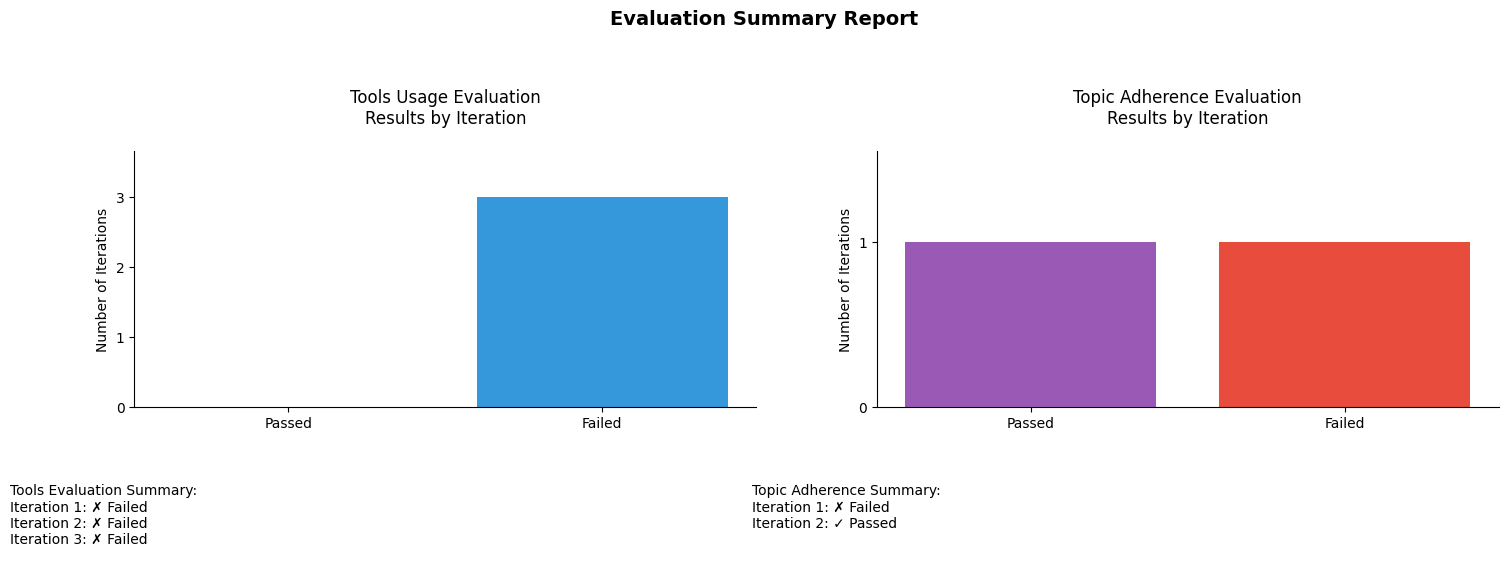

In [70]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# --- Tools Evaluation Summary (Left Plot) ---
tools_results = all_tools_eval_results['passed']
tools_stats = {
    'Passed': sum(tools_results),
    'Failed': len(tools_results) - sum(tools_results)
}

# Create summary text for tools
tools_summary = "Tools Evaluation Summary:\n"
for i, passed in enumerate(tools_results):
    status = "✓ Passed" if passed else "✗ Failed"
    tools_summary += f"Iteration {i+1}: {status}\n"

# Plot tools results with blue palette
ax1.bar(['Passed', 'Failed'], 
        [tools_stats['Passed'], tools_stats['Failed']], 
        color=['#2ecc71', '#3498db'])  # Green and Blue
ax1.set_title('Tools Usage Evaluation\nResults by Iteration', pad=20)
ax1.text(-0.2, -0.3, tools_summary, 
         transform=ax1.transAxes, 
         verticalalignment='top',
         fontsize=10)

# --- Topic Adherence Summary (Right Plot) ---
topic_results = [status.lower() == 'true' for status in topic_adherence_eval_results['passed']]
topic_stats = {
    'Passed': sum(topic_results),
    'Failed': len(topic_results) - sum(topic_results)
}

# Create summary text for topic adherence
topic_summary = "Topic Adherence Summary:\n"
for i, status in enumerate(topic_adherence_eval_results['passed']):
    status_text = "✓ Passed" if status.lower() == 'true' else "✗ Failed"
    topic_summary += f"Iteration {i+1}: {status_text}\n"

# Plot topic adherence results with purple palette
ax2.bar(['Passed', 'Failed'], 
        [topic_stats['Passed'], topic_stats['Failed']], 
        color=['#9b59b6', '#e74c3c'])  # Purple and Red
ax2.set_title('Topic Adherence Evaluation\nResults by Iteration', pad=20)
ax2.text(-0.2, -0.3, topic_summary, 
         transform=ax2.transAxes, 
         verticalalignment='top',
         fontsize=10)

# Customize both plots
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Number of Iterations')
    
    # Set y-axis to integers
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Set y-axis limits based on max value
    max_val = max([val for val in ax.get_ylim()])
    ax.set_ylim(0, max_val + 0.5)  # Add some padding at the top
    
# Add overall title
fig.suptitle('Evaluation Summary Report', fontsize=14, fontweight='bold', y=1.05)

# Adjust layout
plt.tight_layout()
plt.show()